In [1]:
import numpy as np
import gpstk
from Toolkit import *
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f1=gpstk.L1_FREQ_GPS
f2=gpstk.L2_FREQ_GPS
factor_alfa=f2**2/(f1**2-f2**2)
c=3e8
alfa=1.0/((f1**2/f2**2)-1) 

In [3]:
def get_arcs(t,Icode,Iphase,ELEV,IPPS,L1,L2,C1,C2): 
    #Returns arcs with observations time, phase & code delay,IPP
    #For every station returns a dictionary
    ##key: Number of arc observed in that day (starting with 0).
    ##values: Phase, Code, etc in that arc
    Phase,Code,Elevation=[],[],[]
    PhaseL1,PhaseL2=[],[]
    CodeL1,CodeL2,IPP=[],[],[]
    notfound=0 
    tnew=[]
    for i in t:
        if i in Iphase.keys(): #all times in 't' should correspond to the keys in the dictionaries.
            if ELEV[i]>10:
                Phase.append(Iphase[i])
                Code.append(Icode[i])
                Elevation.append(ELEV[i])
                PhaseL1.append(L1[i])
                PhaseL2.append(L2[i])
                CodeL1.append(C1[i])
                CodeL2.append(C2[i])
                IPP.append(IPPS[i])
                tnew.append(i)
        else:
            #print "Tiempo no encontrado: ",i
            notfound+=1
            
    if notfound>0:
        print "Tiempos no encontrados :",notfound
    
    t=adjust_times(tnew)
    
    Phase,Code,t,Elevation,PhaseL1,PhaseL2,CodeL1,CodeL2=np.array(Phase),np.array(Code),np.array(t),np.array(Elevation),np.array(PhaseL1),np.array(PhaseL2),np.array(CodeL1),np.array(CodeL2)
    
    limits=[]
    for i in range(1,len(t)):
        if t[i]-t[i-1]>3600: 
            limits.append(i)

    arcs=np.split(range(t.size),limits)
    obs={} #Key: Number arc, Values: array time of observations , arrayPhase Delays, array code etc.
    i=0
    for arc in arcs:
        obs[i]=[t[arc],Phase[arc],Code[arc],Elevation[arc],PhaseL1[arc],PhaseL2[arc],CodeL1[arc],CodeL2[arc]]
        i+=1
    return obs

In [4]:
stations=[[["/mnt/zob1324.03.n","/mnt/zob1324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 26"],
          [["/mnt/zob1324.03.n","/mnt/zob1324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 27"],
          [["/mnt/zob1324.03.n","/mnt/zob1324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 8"],
          [["/mnt/erla324.03.n","/mnt/erla324.03.o"],["/mnt/leba324.03.n","/mnt/leba324.03.o"],"GPS 28"],
          [["/mnt/colb324.03.n","/mnt/colb324.03.o"],["/mnt/mtvr324.03.n","/mnt/mtvr324.03.o"],"GPS 28"],
          [["/mnt/colb324.03.n","/mnt/colb324.03.o"],["/mnt/mtvr324.03.n","/mnt/mtvr324.03.o"],"GPS 26"],
          [["/mnt/woos324.03.n","/mnt/woos324.03.o"],["/mnt/garf324.03.n","/mnt/garf324.03.o"],"GPS 26"],
          [["/mnt/freo324.03.n","/mnt/freo324.03.o"],["/mnt/lsbn324.03.n","/mnt/lsbn324.03.o"],"GPS 26"],
          [["/mnt/erla324.03.n","/mnt/erla324.03.o"],["/mnt/grtn324.03.n","/mnt/grtn324.03.o"],"GPS 28"],
          #[["/mnt/sidn324.03.n","/mnt/sidn324.03.o"],["/mnt/kntn324.03.n","/mnt/kntn324.03.o"],"GPS 28"],
          #[["/mnt/sidn324.03.n","/mnt/sidn324.03.o"],["/mnt/kntn324.03.n","/mnt/kntn324.03.o"],"GPS 26"],
         ]

DCB={"GPS 8":-1.264e-9, "GPS 26":0.442e-9,"GPS 28":2.635e-9 } #PRN: DCB Value in seconds taken from igs ionex files

Funciones

In [5]:
def gradients(stations):
    for pair in stations:
        st1=pair[0]
        st2=pair[1]
        satellite=pair[2]
        
        print "##################################################################"
        print "\n##### Station 1:",st1[0][5:9]," - Station 2:",st2[0][5:9], satellite, "######"

        t1,t2,Icode1,Iphase1,Icode2,Iphase2,VTECphase1,VTECphase2,ELEV1,ELEV2,IPP1,IPP2,L11,L12,L21,L22,C11,C12,C21,C22,Tgd_rinex=getdata_stationpair(st1,st2,satellite)
        obs1=get_arcs(t1,Icode1,Iphase1,ELEV1,IPP1,L11,L12,C11,C12) #gets arcs with Phase, Code, and adjusted times observations
        obs2=get_arcs(t2,Icode2,Iphase2,ELEV2,IPP2,L21,L22,C21,C22) #Lij station i, frecuency Lj
        
        gamma=gpstk.GAMMA_GPS
        if len(obs1)!=len(obs2): # If one of the stations misses one arc
            obs1,obs2=match_arcs(obs1,obs2)

        for arc in range(len(obs1)):#to each arc in a day observed by the two stations
            if arc in obs1 and arc in obs2:
                print "\n*************Arc #"+str(arc+1)+"*************"
                time1,time2=obs1[arc][0],obs2[arc][0] 
                tboth=np.intersect1d(time1,time2)

                t1index,t2index=get_indexes(time1,time2)

                time1=time1[t1index] 
                time2=time2[t2index]

                Phase1=obs1[arc][1][t1index]
                Phase2=obs2[arc][1][t2index]

                Code1=obs1[arc][2][t1index]
                Code2=obs2[arc][2][t2index]

                Elevation1=obs1[arc][3][t1index]
                Elevation2=obs2[arc][3][t2index]
                
                 #Phase on frequency L1,L2 station1
                Phase1L1=obs1[arc][4][t1index]
                Phase1L2=obs1[arc][5][t1index]
                Code1L1=obs1[arc][6][t1index]
                Code1L2=obs1[arc][7][t1index]

                #Phase on frequency L1,L2 station 2
                Phase2L1=obs2[arc][4][t2index]
                Phase2L2=obs2[arc][5][t2index]
                Code2L1=obs2[arc][6][t2index]
                Code2L2=obs2[arc][7][t2index]

                #Get distance between Ionospheric pearce points
                D=distance_betweenIPPS(IPP1,IPP2,tboth)
               
                #Detect data jumps on L=L1-L2
                jumps1=datajump(Phase1,2.5)
                jumps2=datajump(Phase2,2.5)
                
                #Divide in Sub-arcs using jumps
                miniarcs1=sub_arcs(Phase1,jumps1)
                miniarcs2=sub_arcs(Phase2,jumps2)

                #Remove short arcs 
                print "\nRemove short arcs"
                if len(jumps1)>0:
                    miniarcs1,miniarcs2=remove_short(miniarcs1,miniarcs2)
                if len(jumps2)>0:
                    miniarcs2,miniarcs1=remove_short(miniarcs2,miniarcs1)

                #Polinomial fit and Outlier Detection
                ##On each subarc check for slips and delete.
                pslips1=[] #slips in st1 with polinomyal fit
                pslips2=[] #slips in st2 with polinomyal fit
                oslips1=[] #slips in st1 oulier factor
                oslips2=[] #slips in st2 oulier factor

                for i in miniarcs1:#In station1 #probar reemplazando solo por i
                    __,pslip=poly_fit(Phase1[i],time1[i])
                    pslips1.append(pslip)
                    __,oslip=outlier_detect(Phase1[i],time1[i]*3600)
                    oslips1.append(oslip)

                for i in miniarcs2:#In station2
                    __,pslip=poly_fit(Phase2[i],time2[i])
                    pslips2.append(pslip)
                    __,oslip=outlier_detect(Phase2[i],time2[i]*3600)
                    oslips2.append(oslip)

                ##Using polinompyal fit and outlier factor methods we confirm slips
                confirmed1=[] #a list of lists with the confirmed outliers on each subarc
                confirmed2=[]

                for i in miniarcs1:
                    outliers=confirmed_slip(time1[i],Phase1[i])
                    confirmed1.append(outliers)

                for i in miniarcs2:
                    outliers=confirmed_slip(time2[i],Phase2[i])
                    confirmed2.append(outliers) 

                #Remove slips from both stations
                for i in range(len(confirmed1)):
                    if len(confirmed1[i])!=0:
                        miniarcs1[i],miniarcs2=remove_slip(miniarcs1[i],miniarcs2,oslips1[i])

                for i in range(len(confirmed2)):
                    if len(confirmed2[i])!=0:
                        miniarcs2[i],miniarcs1=remove_slip(miniarcs2[i],miniarcs1,oslips2[i])
            
            
                #Hatch Filter for code smoothing on every frequency before leveling
                #in every subarc
                newC11,newC12=Code1,Code2
                newC21,newC22=Code1,Code2
                for i in miniarcs1:
                    newC11[i]=Smooth_code(Code1L1[i],Phase1L1[i])
                    newC12[i]=Smooth_code(Code1L2[i],Phase1L2[i])
                    
                for i in miniarcs2:
                    newC21[i]=Smooth_code(Code2L1[i],Phase2L1[i])
                    newC22[i]=Smooth_code(Code2L2[i],Phase2L2[i])
            
                
                newC1=(newC12-newC11)*alfa
                newC2=(newC22-newC21)*alfa
                
                #Leveling Phase
                PhaseArc1,PhaseArc2=[],[] #lists with subarcs leveled
                C1,C2=[],[]
                PhaseL11,PhaseL12=[],[]
                PhaseL21,PhaseL22=[],[]
                IPPD=[]

                for i in miniarcs1:
                    Lfactor,new_IPHASE_arc=levelphase(newC1[i],Phase1[i],Elevation1[i])
                    PhaseArc1.append(new_IPHASE_arc)  
                    C1.append(newC1[i])
                    IPPD.append(D[i])

                for i in miniarcs2:
                    Lfactor,new_IPHASE_arc=levelphase(newC2[i],Phase2[i],Elevation2[i])
                    PhaseArc2.append(new_IPHASE_arc)
                    C2.append(newC2[i])
                    

                #Here all subarcs are merged into one single corrected continuous arc.
                new_IPHASE_arc1,new_IPHASE_arc2=np.hstack(PhaseArc1),np.hstack(PhaseArc2)
                C1,C2=np.hstack(C1),np.hstack(C2)
                IPPD=np.hstack(IPPD)
                ntimes1,ntimes2=np.array([]),np.array([])

                for i in miniarcs1:
                    ntimes1=np.append(ntimes1,time1[i])

                for i in miniarcs2:
                    ntimes2=np.append(ntimes2,time2[i])
                    
                #Checking times and measures are the same size
                print "# Observations st1: ",ntimes1.size,new_IPHASE_arc1.size
                print "# Observations st2: ",ntimes2.size,new_IPHASE_arc2.size
                print "# Distances: ",IPPD.size


                 #************Remove IFB and receiver bias from leveled phase***************************
                #The method utilizes the satellite hardware biases already determined from other parties.
                #GPS satellite hardware bias, τg is calculated from DCB
                ##Total group delay
                #print "DCB",DCB[satellite] ,"seconds"
                #Tgd=DCB[satellite]*factor_alfa*c
                Tgd=Tgd_rinex*factor_alfa*c
                print "Tgd from ionex",Tgd_rinex
                #Tgd affects both code and carrier measures
                new_IPHASE_arc1-=Tgd
                new_IPHASE_arc2-=Tgd
                ################Inter Frequency Biases##################################################


                ##########################################################################################
                ##Finally delay and code
                d=IPPD/1000 #Km
                IONO_Phase=(new_IPHASE_arc1-new_IPHASE_arc2)*1000/d #mm
                IONO_Code=(C1-C2)*1000/d


                plt.figure(figsize=(16,10))

                plt.subplot(2,2,1)
                title="For arc #"+str(arc+1)+st1[0][5:9]+" and "+st2[0][5:9]+" Carrier Phase "+satellite
                plt.title(title)
                plt.xlabel("Hour of the day")
                plt.ylabel("Delay [meters]")
                plt.scatter(ntimes1/3600,new_IPHASE_arc1,color="blue",label=st1[0][5:9])
                plt.plot(ntimes1/3600,new_IPHASE_arc1,color="blue")
                plt.scatter(ntimes2/3600,new_IPHASE_arc2,color="green",label=st2[0][5:9])
                plt.plot(ntimes2/3600,new_IPHASE_arc2,color="green")
                plt.legend()


                plt.subplot(2,2,2)
                title="Gradient Phase "+st1[0][5:9]+"-"+st2[0][5:9]+satellite
                plt.title(title)
                plt.xlabel("Hour of the day")
                plt.ylabel("Gradient [mm/Km]")
                plt.scatter(ntimes2/3600,IONO_Phase,color="purple",alpha=0.5)
                plt.plot(ntimes2/3600,IONO_Phase,color="purple")
                print "Biggest grdient Carrier: ",np.max(IONO_Phase)
                print "Time of biggest gradient: ",ntimes2[np.argmax(IONO_Phase)]/3600

                plt.subplot(2,2,3)
                title="For arc #"+str(arc+1)+st1[0][5:9]+" and "+st2[0][5:9]+" Code"+satellite
                plt.title(title)
                plt.xlabel("Hour of the day")
                plt.ylabel("Delay [meters]")
                plt.scatter(ntimes1/3600,C1,color="blue",label=st1[0][5:9])
                plt.plot(ntimes1/3600,C1,color="blue")
                plt.scatter(ntimes2/3600,C2,color="green",label=st2[0][5:9])
                plt.plot(ntimes1/3600,C2,color="green")
                plt.legend()

                plt.subplot(2,2,4)
                title="Gradient Code "+st1[0][5:9]+"-"+st2[0][5:9]+satellite
                plt.title(title)
                plt.xlabel("Hour of the day")
                plt.ylabel("Gradient [mm/Km]")
                plt.scatter(ntimes2/3600,IONO_Code,color="red",alpha=0.5)
                plt.plot(ntimes2/3600,IONO_Code,color="red")
                print "Biggest grdient Code: ",np.max(IONO_Code)
                print "Time of biggest gradient: ",ntimes2[np.argmax(IONO_Code)]/3600
                


##################################################################

##### Station 1: zob1  - Station 2: garf GPS 26 ######

*************Arc #1*************

Remove short arcs
# Observations st1:  627 627
# Observations st2:  627 627
# Distances:  627
Tgd from ionex -6.51925802231e-09
Biggest grdient Carrier:  3.68301177898
Time of biggest gradient:  9.23333333333
Biggest grdient Code:  0.0
Time of biggest gradient:  4.05

*************Arc #2*************

Remove short arcs
# Observations st1:  58 58
# Observations st2:  58 58
# Distances:  58
Tgd from ionex -6.51925802231e-09
Biggest grdient Carrier:  357.887957038
Time of biggest gradient:  21.2916666667
Biggest grdient Code:  0.0
Time of biggest gradient:  20.7833333333
##################################################################

##### Station 1: zob1  - Station 2: garf GPS 27 ######

*************Arc #1*************

Remove short arcs
# Observations st1:  690 690
# Observations st2:  690 690
# Distances:  690
Tgd from ionex 

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
Toolkit.py:347: RuntimeWarning: invalid value encountered in double_scalars
  L=np.sum((ICODE-IPHASE)*(np.sin(ELEV)**2))/np.sum((np.sin(ELEV))**2) #leveling factor
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankW

 0.0
Time of biggest gradient:  5.80833333333

*************Arc #2*************

Remove short arcs
# Observations st1:  608 608
# Observations st2:  608 608
# Distances:  608
Tgd from ionex -4.19095158577e-09
Biggest grdient Carrier:  470.766781109
Time of biggest gradient:  20.9916666667
Biggest grdient Code:  0.0
Time of biggest gradient:  17.9083333333
##################################################################

##### Station 1: erla  - Station 2: leba GPS 28 ######

*************Arc #1*************

Remove short arcs
# Observations st1:  154 154
# Observations st2:  154 154
# Distances:  154
Tgd from ionex -1.02445483208e-08
Biggest grdient Carrier:  0.857150761515
Time of biggest gradient:  0.0166666666667
Biggest grdient Code:  0.0
Time of biggest gradient:  0.0

*************Arc #2*************

Remove short arcs
# Observations st1:  629 629
# Observations st2:  629 629
# Distances:  629
Tgd from ionex -1.02445483208e-08
Biggest grdient Carrier:  217.651722504
Time of big

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


 0.0
Time of biggest gradient:  0.0

*************Arc #2*************

Remove short arcs
# Observations st1:  627 627
# Observations st2:  627 627
# Distances:  627
Tgd from ionex -1.02445483208e-08
Biggest grdient Carrier:  198.358677115
Time of biggest gradient:  21.025
Biggest grdient Code:  0.0
Time of biggest gradient:  18.7666666667
##################################################################

##### Station 1: colb  - Station 2: mtvr GPS 26 ######

*************Arc #1*************

Remove short arcs
# Observations st1:  624 624
# Observations st2:  624 624
# Distances:  624
Tgd from ionex -6.51925802231e-09
Biggest grdient Carrier:  2.49333607504
Time of biggest gradient:  4.64166666667
Biggest grdient Code:  0.0
Time of biggest gradient:  4.01666666667

*************Arc #2*************

Remove short arcs
# Observations st1:  89 89
# Observations st2:  89 89
# Distances:  89
Tgd from ionex -6.51925802231e-09
Biggest grdient Carrier:  243.720707093
Time of biggest gradient: 

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


 0.0
Time of biggest gradient:  4.05

*************Arc #2*************

Remove short arcs
# Observations st1:  59 59
# Observations st2:  59 59
# Distances:  59
Tgd from ionex -6.51925802231e-09
Biggest grdient Carrier:  237.288576599
Time of biggest gradient:  21.2916666667
Biggest grdient Code:  0.0
Time of biggest gradient:  20.7833333333
##################################################################

##### Station 1: freo  - Station 2: lsbn GPS 26 ######

*************Arc #1*************

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Poly



Remove short arcs
# Observations st1:  631 631
# Observations st2:  631 631
# Distances:  631
Tgd from ionex -6.51925802231e-09
Biggest grdient Carrier:  1.8955682857
Time of biggest gradient:  4.41666666667
Biggest grdient Code:  0.0
Time of biggest gradient:  4.025

*************Arc #2*************

Remove short arcs
# Observations st1:  48 48
# Observations st2:  48 48
# Distances:  48
Tgd from ionex -6.51925802231e-09
Biggest grdient Carrier:  143.252343193
Time of biggest gradient:  21.2666666667
Biggest grdient Code:  0.0
Time of biggest gradient:  20.9
##################################################################

##### Station 1: erla  - Station 2: grtn GPS 28 ######

*************Arc #1*************

Remove short arcs
# Observations st1:  156 156
# Observations st2:  156 156
# Distances:  156
Tgd from ionex -1.02445483208e-08
Biggest grdient Carrier:  0.398471211236
Time of biggest gradient:  0.208333333333
Biggest grdient Code: 

/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)
/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


 0.0
Time of biggest gradient:  0.0

*************Arc #2*************

Remove short arcs
# Observations st1:  629 629
# Observations st2:  629 629
# Distances:  629
Tgd from ionex -1.02445483208e-08
Biggest grdient Carrier:  195.559505162
Time of biggest gradient:  21.1583333333
Biggest grdient Code:  0.0
Time of biggest gradient:  18.7


/opt/anaconda/lib/python2.7/site-packages/numpy/lib/polynomial.py:588: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


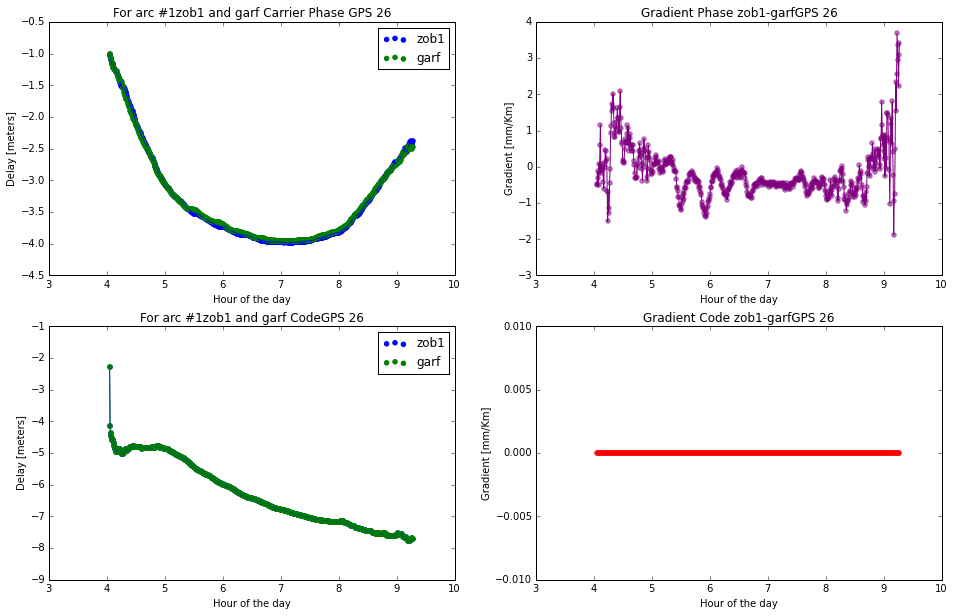

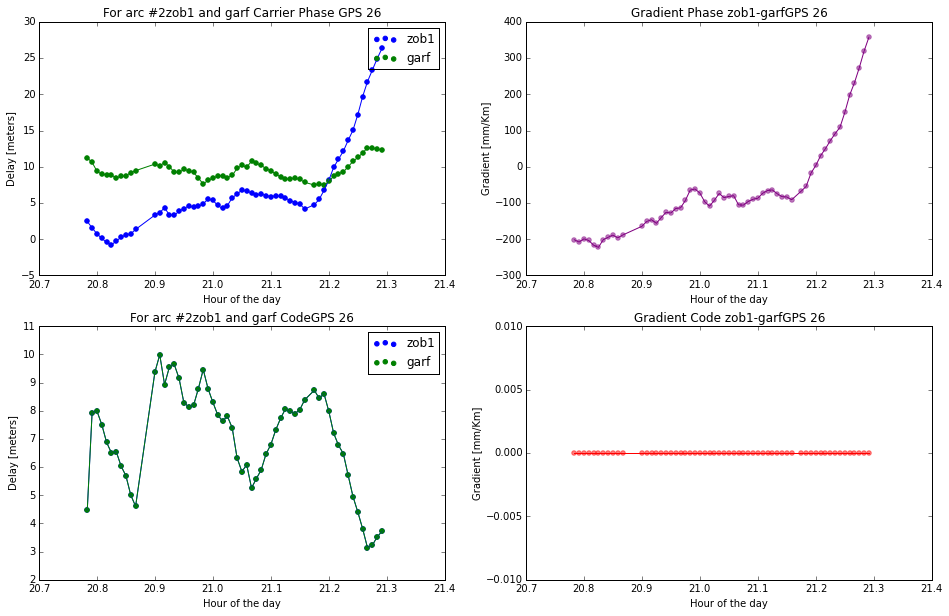

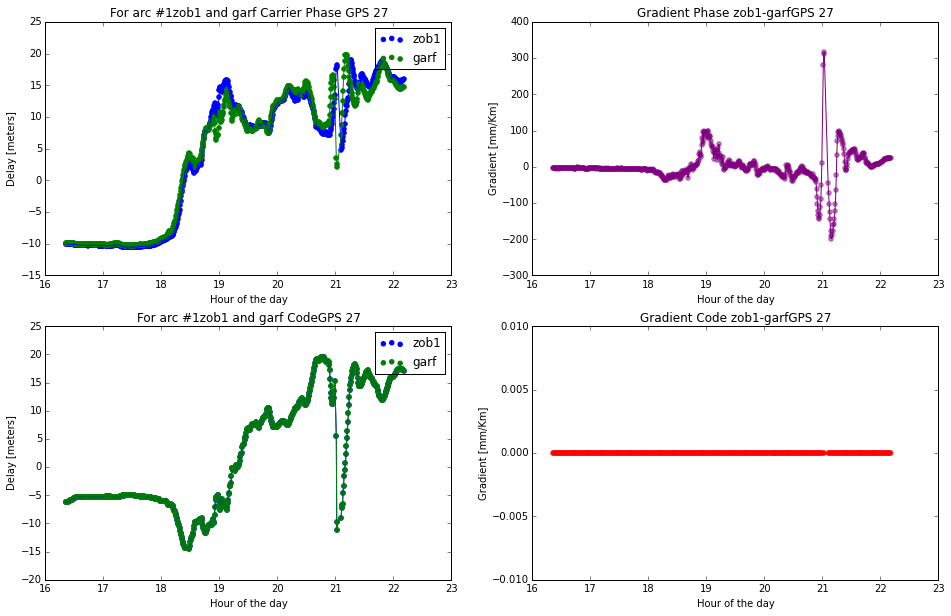

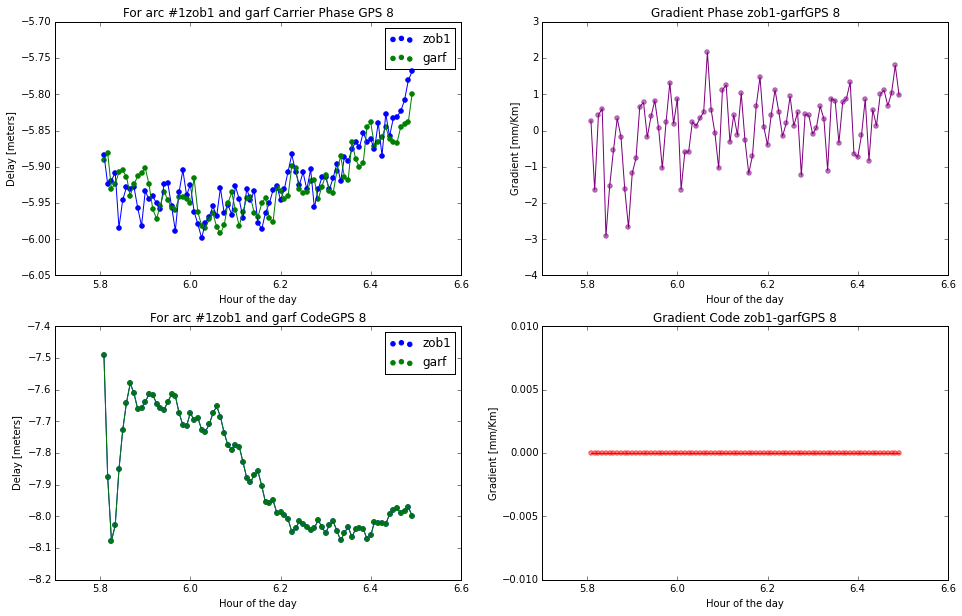

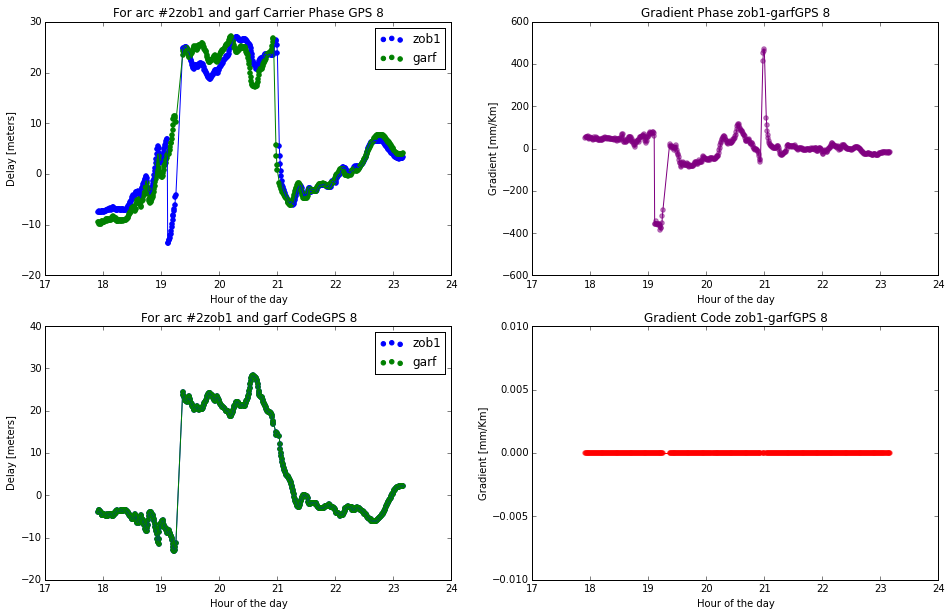

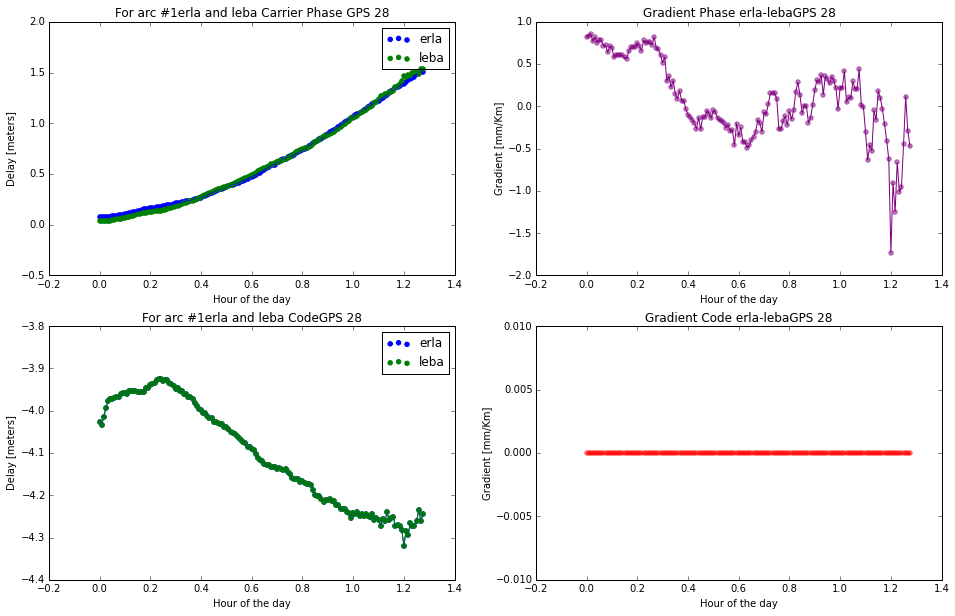

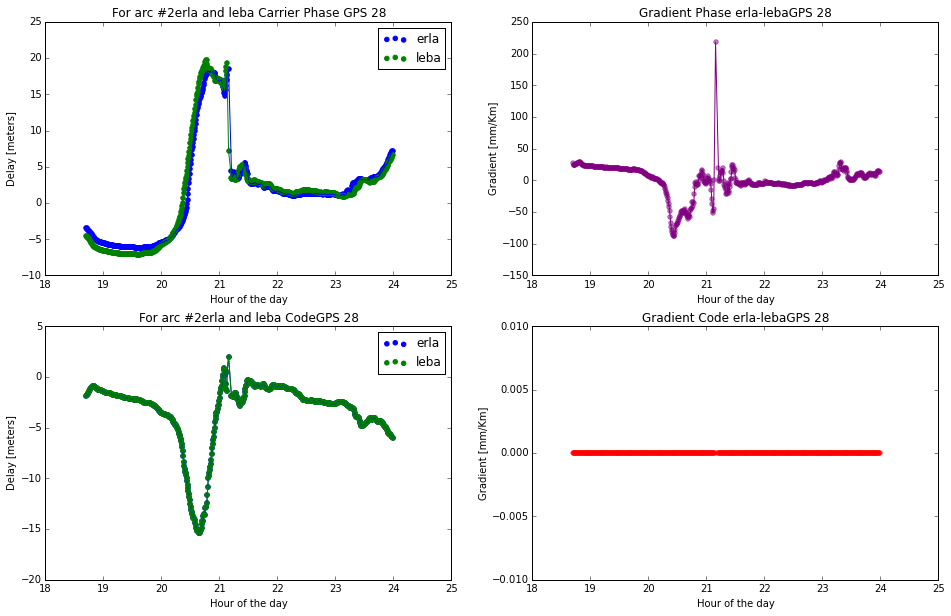

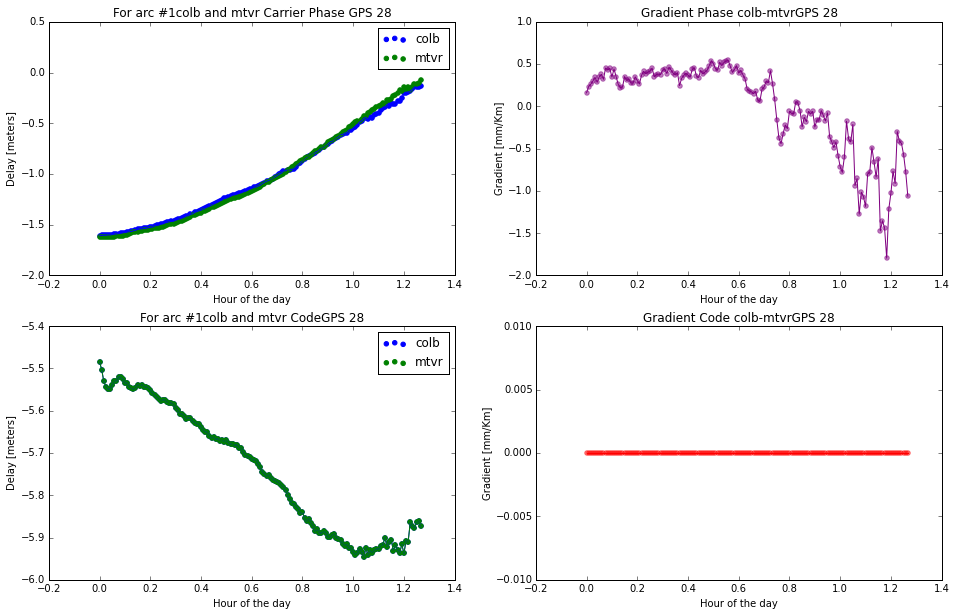

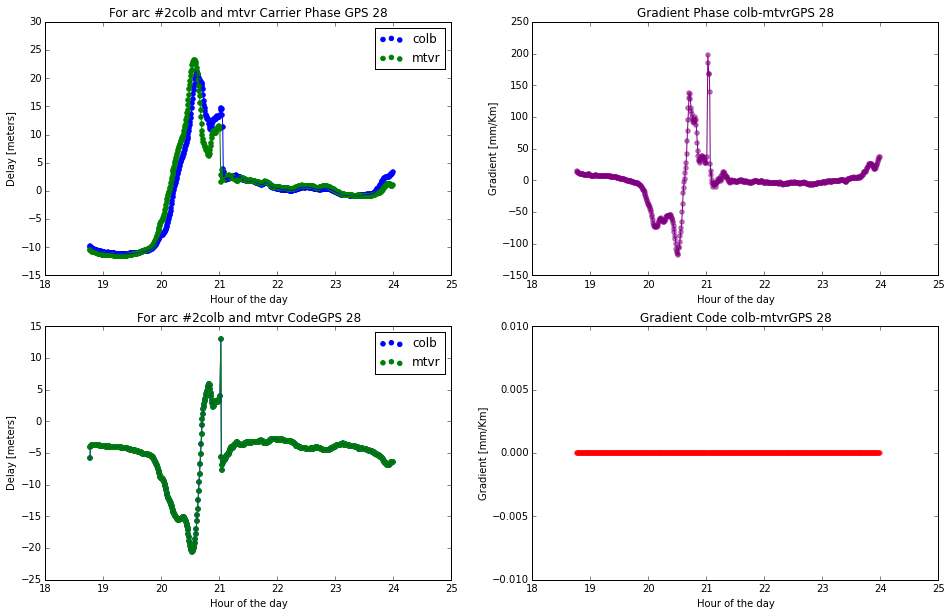

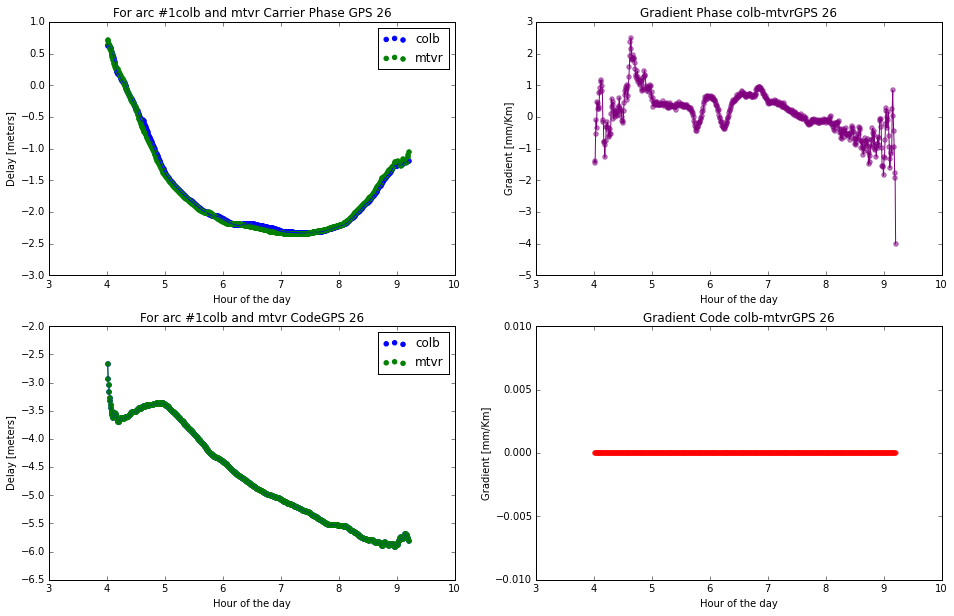

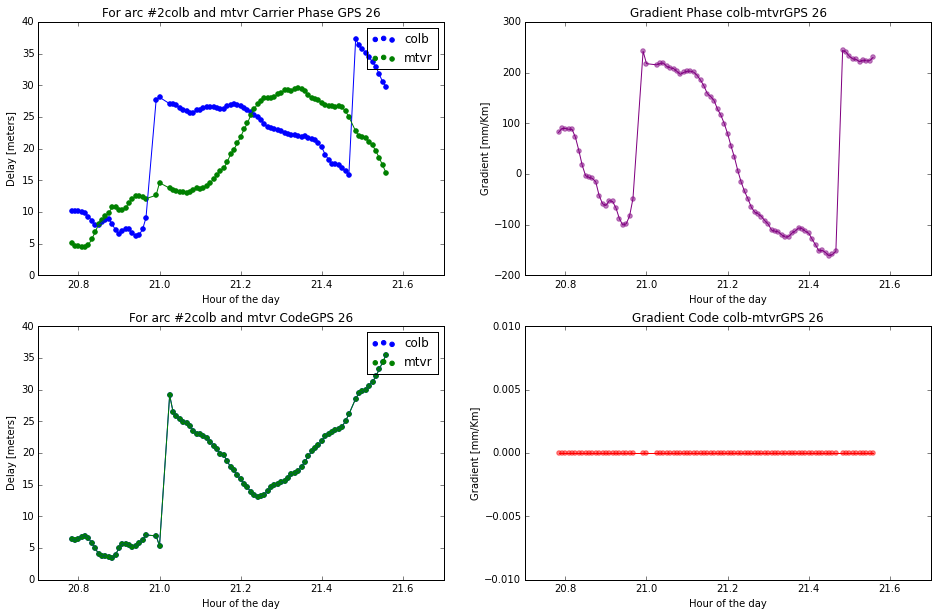

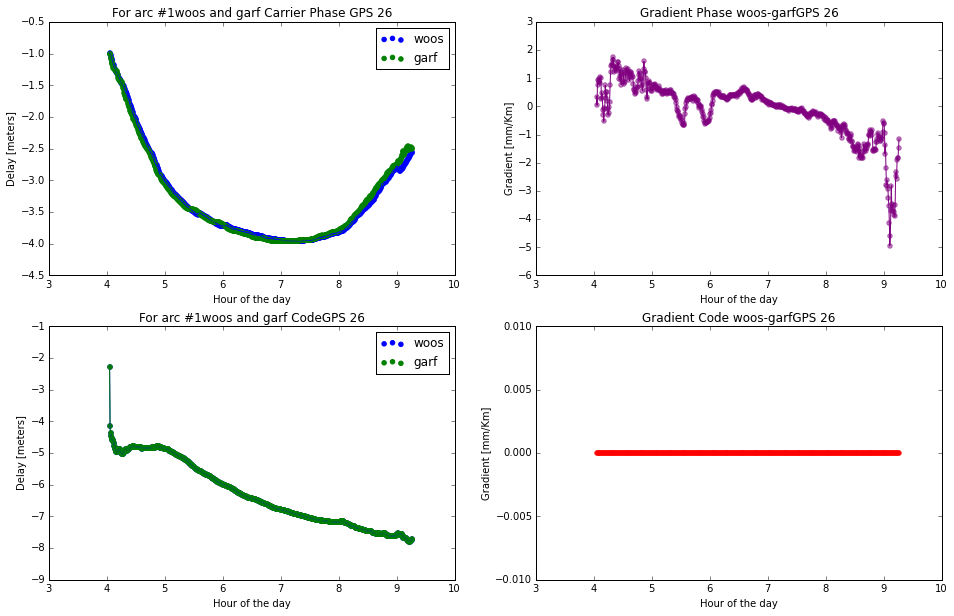

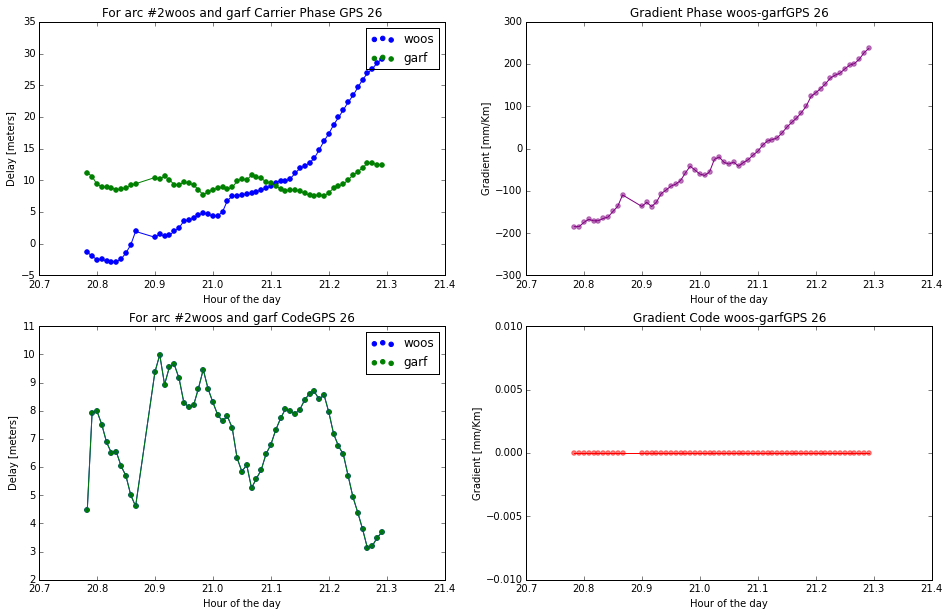

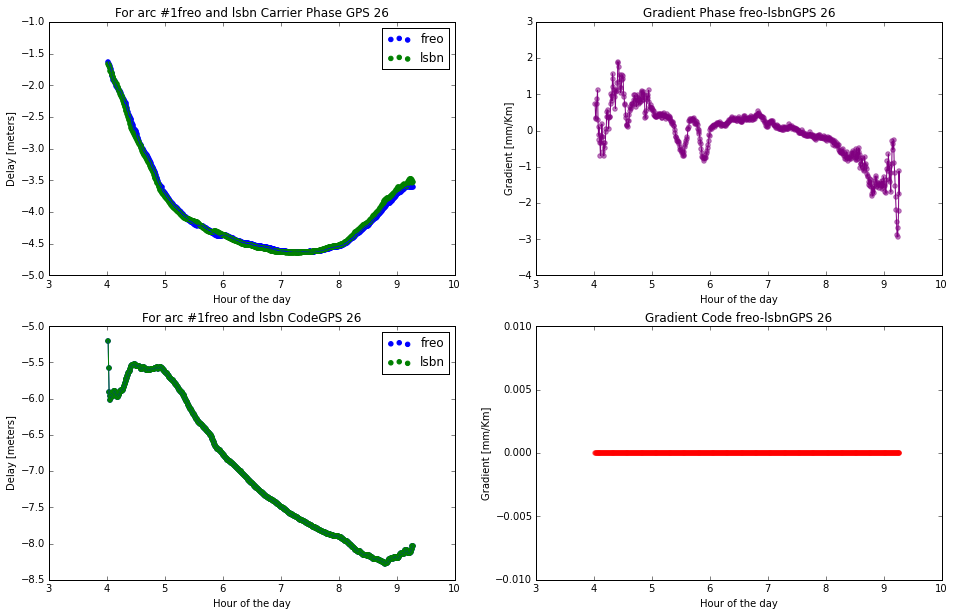

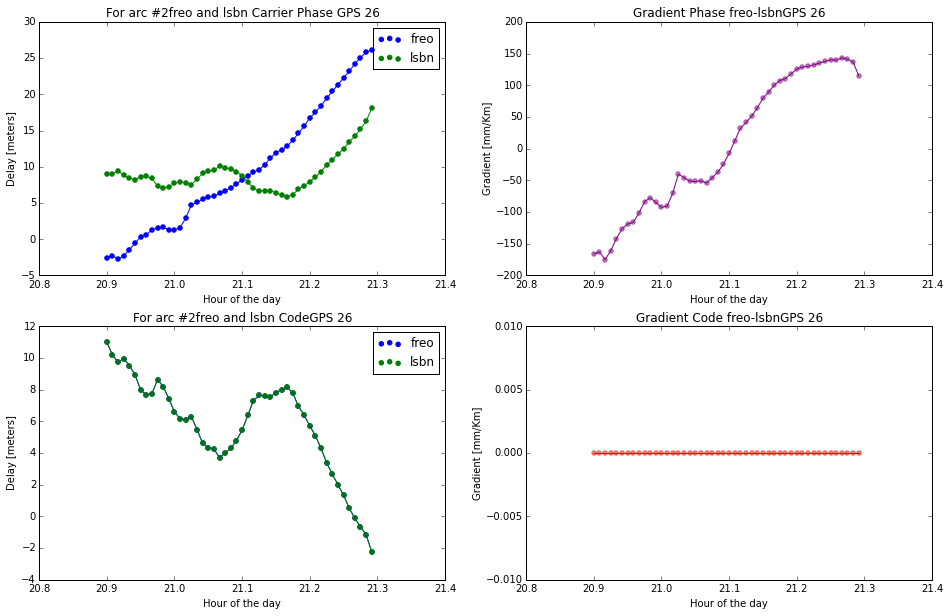

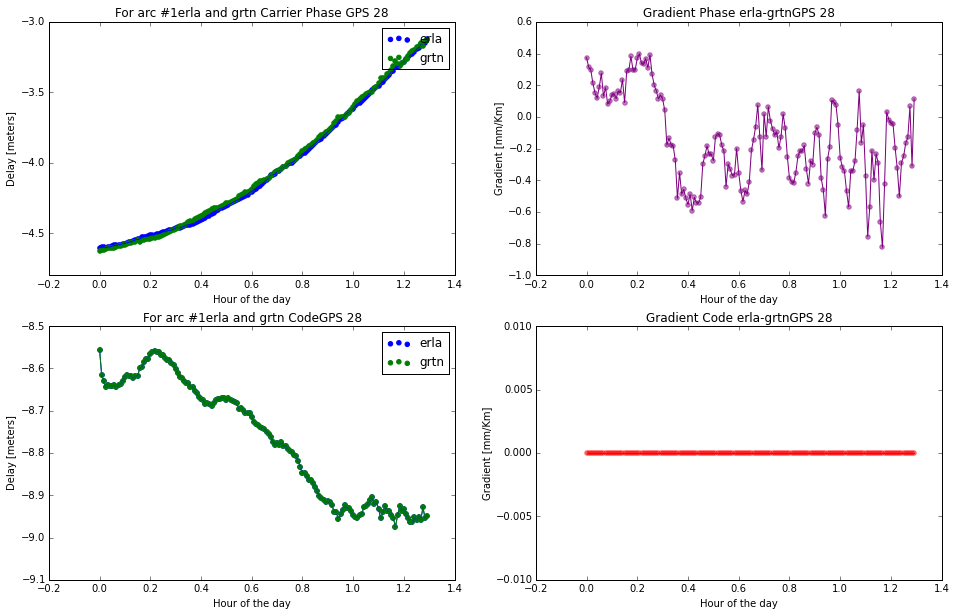

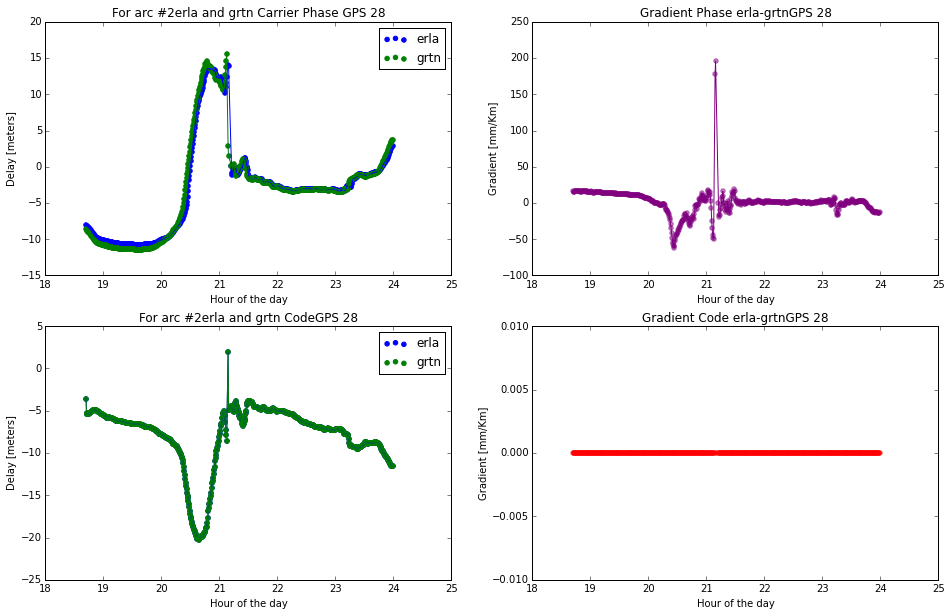

In [6]:
gradients(stations)